<a href="https://colab.research.google.com/github/alexander-n-thomas/spark-nlp-book-prod/blob/master/2_7_Classification_and_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 61kB/s 
     |████████████████████████████████| 204kB 54.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130388 sha256=784345438dcfa4cb75d871b2639d6f5131887a85f7349975accc7df6841e67c7
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 122kB 7.9MB/s 


In [2]:
! mkdir -p data

In [3]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2020-07-23 21:12:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz’

mini_newsgroups.tar 100%[===================>]   1.77M  1.85MB/s    in 1.0s    

2020-07-23 21:12:42 (1.85 MB/s) - ‘mini_newsgroups.tar.gz’ saved [1860687/1860687]



In [4]:
! tar xzf mini_newsgroups.tar.gz -C ./data/

# Classification and Regression

The most common machine learning tasks performed on documents are classification and regression. From determining insurance billing codes for a clinical note (classification) to predicting the popularity of a social media post (regression), most document-level machine learning tasks fall into one of these categories, with classification being the much more common of the two.

When beginning a machine learning task, it is very informative to try and manually label some documents, even if there are already labels in the data set. This will help you understand what content in the language of the documents can be used in your task. When labeling, note what you look for. For example, particular words or phrases, certain sections of the document, and even document length can be useful.

In a chapter about classification and regression, you might expect most of the discussion to be about different modeling algorithms. With NLP, most of the work is in the featurization. Many of the general techniques for improving models will work with NLP, assuming you have created good features. We will go over some of the considerations for tuning modeling algorithms, but most of this chapter focuses on how to featurize text for classification and regression.

We'll discuss the bag-of-words approach, regular expression-based features, and feature selection. After this, we will talk about how to iterate when building a model on text data.

Let's load and process the mini_newsgroups data, so we can see examples of how to create these features.

In [5]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

%matplotlib inline

spark = sparknlp.start()

We will build a classifier to identify which newsgroup a document is from. The newsgroup is mentioned in the header of the documents, so let's remove those to be more sporting.

In [6]:
HEADER_PTN = re.compile(r'^[a-zA-Z-]+:.*')

def remove_header(path_text_pair):
    path, text = path_text_pair
    lines = text.split('\n')
    line_iterator = iter(lines)
    while HEADER_PTN.match(next(line_iterator)) is not None:
        pass
    return path, '\n'.join(line_iterator)

In [44]:
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path).map(remove_header)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema) \
    .withColumn('newsgroup', expr('split(path, "/")[4]')) \
    .persist()

In [45]:
texts.groupBy('newsgroup').count().collect()

[Row(newsgroup='comp.windows.x', count=100),
 Row(newsgroup='misc.forsale', count=100),
 Row(newsgroup='rec.sport.hockey', count=100),
 Row(newsgroup='rec.sport.baseball', count=100),
 Row(newsgroup='talk.politics.guns', count=100),
 Row(newsgroup='talk.politics.misc', count=100),
 Row(newsgroup='comp.os.ms-windows.misc', count=100),
 Row(newsgroup='comp.sys.ibm.pc.hardware', count=100),
 Row(newsgroup='comp.graphics', count=100),
 Row(newsgroup='soc.religion.christian', count=100),
 Row(newsgroup='comp.sys.mac.hardware', count=100),
 Row(newsgroup='talk.religion.misc', count=100),
 Row(newsgroup='talk.politics.mideast', count=100),
 Row(newsgroup='rec.motorcycles', count=100),
 Row(newsgroup='rec.autos', count=100),
 Row(newsgroup='alt.atheism', count=100),
 Row(newsgroup='sci.electronics', count=100),
 Row(newsgroup='sci.space', count=100),
 Row(newsgroup='sci.med', count=100),
 Row(newsgroup='sci.crypt', count=100)]

In [46]:
print(texts.first()['path'])
print(texts.first()['newsgroup'])
print(texts.first()['text'])

file:/content/data/mini_newsgroups/rec.sport.hockey/53625
rec.sport.hockey
In article <vzhivov.735059801@cunews>, vzhivov@superior.carleton.ca (Vladimir
Zhivov) says:
>
>In <93107.091503RAP115@psuvm.psu.edu> Robbie Po <RAP115@psuvm.psu.edu> writes:
>
>>2-Red Wings vs. 3-Maple Leafs               Maple Leafs in 6
>
>>  Comment : It's kind of tough to rely on Yzerman as the team's main weapon.
>>            He's a great palyer, but Dino knows all about choking, which
>>            puts the burden on Steve even more.  Potvin's had a hell of a
>>            season and goaltending is what you need in the playoffs.
>
>For a great prognosticator:), you seem to remember very little playoff
>history. Dino always shows up in the playoffs, which is why he is a
>great "sleeper" pick in pools. Don't forget about Fedorov, one of the
>top players in the NHL, IMHO, and Coffey who has the most Stanley Cup
>rings of any active players (correct me if I'm wrong). Wings in a
>cakewalk.

Oh yeah, how come D

In [10]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)
pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, finisher
]).fit(texts)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [11]:
processed = pipeline.transform(texts).persist()

In [12]:
print(processed.count()) # number of documents

2000


## Bag-of-Words Features

In the previous chapter we discussed document vectors built with TF.IDF. These features are the most common kinds of features used in document classification and regression. There is some difficulty in using features like this, however. Depending on the size of your corpus, you could potentially have more than a hundred thousand features, where any example will have only a few hundred to a few thousand nonzero features. This can be handled by creating a sparse representation of your feature matrix, where 0 values are omitted. However, not all training algorithms support sparse matrices. This is where the vocabulary reduction techniques we discussed in #processing_words become important.


If you have already reduced your vocabulary, but you still need to reduce the number of your features, it is time to consider using a restricted vocabulary. For example, when working with clinical data, it might be best to restrict your vocabulary to medical terminology. This can be done by using external resources like the Unified Medical Language Service (UMLS). If you are working in other domains, consider curating a wordlist. Curated vocabularies can be a filter for your features. There are some pros and cons to such vocabularies, though. They are not biased by the information in your data set, so they will not contribute to overfitting. Conversely, there may be features that are unlikely to show up in a generalized curated list that are genuinely useful. This is why it is important for you to label some examples during iterations of your model building. If you have filtered your vocabulary, you can sample the erroneously classified examples for additions to your vocabulary.

The extension of this manual feature selection is trying to combine parts of the vocabulary into a smaller set of features. This can be done with regular expressions.

Let's look at an example of bag-of-words in Spark

In [13]:
from pyspark.ml.feature import CountVectorizer, IDF

count_vectorizer = CountVectorizer(
    inputCol='normalized', outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

bow_pipeline = Pipeline(stages=[count_vectorizer, idf])
bow_pipeline = bow_pipeline.fit(processed)

bows = bow_pipeline.transform(processed)

In [14]:
bows.limit(5).toPandas()[['tf', 'tfidf']]

,tf,tfidf
0,"(16.0, 8.0, 8.0, 7.0, 12.0, 6.0, 3.0, 13.0, 1....","(1.1691290860237853, 0.7321541874305568, 1.053..."
1,"(30.0, 10.0, 3.0, 4.0, 10.0, 4.0, 8.0, 10.0, 4...","(2.192117036294597, 0.915192734288196, 0.39524..."
2,"(4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, ...","(0.2922822715059463, 0.0915192734288196, 0.131..."
3,"(13.0, 6.0, 4.0, 10.0, 2.0, 3.0, 7.0, 4.0, 3.0...","(0.9499173823943255, 0.5491156405729176, 0.526..."
4,"(5.0, 9.0, 4.0, 7.0, 3.0, 3.0, 2.0, 3.0, 3.0, ...","(0.3653528393824329, 0.8236734608593764, 0.526..."


## Regular Expression Features

Let's say you are trying to separate short stories into genres. For this example, we have only three genres in our corpus: science fiction, fantasy, and horror. We can create specific features to help us classify. If we have word lists, we can combine them into a single feature. There are a couple of ways to do this.

* Use bag-of-words features and create a feature that is the result of aggregating the TF.IDF values of the features with sum or max.
* Create a new feature by creating a new token. You can preprocess the documents, adding a tag to any document that contains a word from the vocabulary. You can then calculate TF.IDF for this tag.

We can add other kinds of features. For example, it is common in science fiction to refer to rare and fictional minerals—for example, dilithium (both a real substance and a fictional mineral in Star Trek) and adamantium (a fictional alloy in Marvel comics). We could create a regular expression that looks for the common endings to these minerals.

* `(lith|ant|an)ium`

Discovering which of these features will help us classify is a task on which the data scientist and the domain expert should collaborate. The data scientist can find features that are potentially helpful to the model. The domain expert can identify which features are actually related to the problem and which are spuriously correlated with the target variable.

These features are useful for a first version of a model, but they have some serious drawbacks. If you wish to build a similar model on text in another language, it is very likely that you will not be able to reuse regular expression features.

Let's use the RegexMatcher from Spark NLP for finding matches in the text of the document.

In [15]:
%%writefile scifi_rules.tsv
\w+(lith|ant|an)ium,mineral
(alien|cosmic|quantum|dimension(al)?),space_word

Writing scifi_rules.tsv


In [16]:
regex_matcher = RegexMatcher() \
    .setOutputCol("regex") \
    .setExternalRules('./scifi_rules.tsv', ',')

Because the RegexMatcher works on the raw text, it does not need the other stages. Normally, you would extract the regex matches along with other text-based features. 

In [17]:
regex_finisher = Finisher()\
    .setInputCols(['regex'])\
    .setOutputCols(['regex'])\
    .setOutputAsArray(True)

regex_rule_pipeline = Pipeline().setStages([
    assembler, regex_matcher, regex_finisher
]).fit(texts)

regex_matches = regex_rule_pipeline.transform(texts)

In [18]:
regex_matches.orderBy(expr('size(regex)').desc())\
    .limit(5).toPandas()[['newsgroup', 'regex']]

,newsgroup,regex
0,None,"[alien, alien, alien, alien, alien, alien, alien]"
1,None,"[dimensional, dimension, dimensional, dimension]"
2,None,"[cosmic, cosmic, cosmic]"
3,None,"[dimensional, alien, dimensional]"
4,None,"[quantum, quantum, cosmic]"


There are a few ways in which these can be turned into features. You can create binary features—in other words, the value is 1 if any of the regexes match. You can also use the number of matches as a feature.

Now that we have introduced two of the most common classic NLP features, let's talk about how we reduce our dimensions.

## Feature Selection
  Once you have determined a set of features, often a mix of bag-of-words and regular expressions, you may find that you have a very high dimensional feature space. This will depend very much on the sort of language used in the corpus. In highly technical corpora, it is not uncommon to have more features than examples. If you look at the distribution, you will see that they are distributed by a power law.

We can use the Spark `StopWordsRemover` to remove words like "the" and "of," like we discussed in "Information Retrieval".

In [19]:
from pyspark.ml.feature import StopWordsRemover

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

Finally, we turn this into a pipeline. It is important to include your text processing steps in your pipeline. This will let you explore hyperparameters of your machine learning model alongside NLP parameters. This gets more important the more complex your NLP preprocessing becomes. We will also include our bag-of-words stages.

In [20]:
count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

pipeline = Pipeline() \
    .setStages([
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ]) \
    .fit(texts)

Now that we have our pipeline constructed, we transform our texts.

In [21]:
features = pipeline.transform(texts).persist()

In [22]:
features.printSchema()

root
 |-- path: string (nullable = true)
 |-- text: string (nullable = true)
 |-- newsgroup: string (nullable = true)
 |-- normalized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In Spark MLlib, the features are stored in a single vector-valued column. This is much more efficient than creating a column for each of the features, but it does make interacting with the data more complicated. To deal with this, we will be pulling the data into a pandas DataFrame. We can do this because our data is small and can fit in memory. This would not work on a larger data set.

Now that we have a fitted `CountVectorizerModel`, we can look at the vocabulary it found. The words are sorted by document frequency.

In [23]:
pipeline.stages

[DocumentAssembler_13e26bdc1088,
 SentenceDetector_c4c7a603f2f8,
 REGEX_TOKENIZER_a6cf775762ec,
 LEMMATIZER_c62ad8f355f9,
 NORMALIZER_f52a4d9c95a5,
 Finisher_2bb2afd5d7bf,
 StopWordsRemover_9f668759275c,
 CountVectorizer_d85757be7a2f,
 IDF_3dd8820dcd44]

In [24]:
cv_model = pipeline.stages[-2]

In [25]:
len(cv_model.vocabulary)

3033

This is a modest vocabulary size. We will see larger sizes when we get to "Applications" part of this book.

Let's look at our top 10 words by document frequency.

In [26]:
cv_model.vocabulary[:10]

['write', 'one', 'use', 'get', 'article', 'say', 'know', 'x', 'make', 'dont']

Let's look at the distribution of mean term frequency. We will create a histogram of mean term frequency

In [27]:
tf = features.select('tf').toPandas()
tf = tf['tf'].apply(lambda sv: sv.toArray())
mean_tf = pd.Series(tf.mean(), index=cv_model.vocabulary)

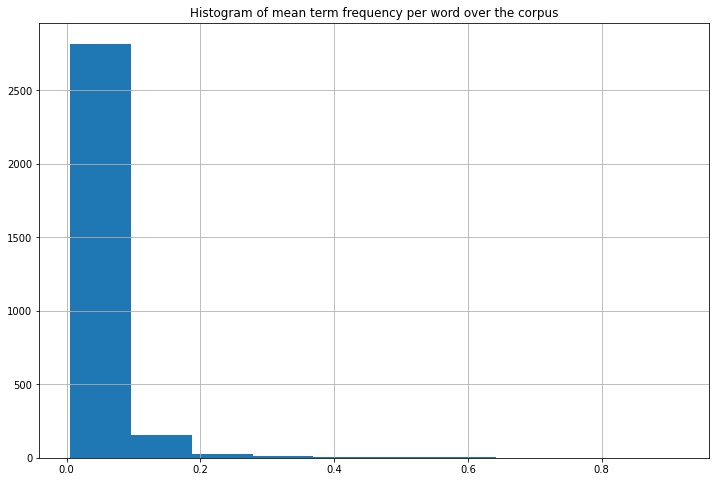

In [30]:
plt.figure(figsize=(12, 8))
mean_tf.hist(bins=10)
plt.title('Histogram of mean term frequency per word over the corpus')
plt.show()

We can see that this looks like a power law distribution. Let's plot the log of the ranks versus the log of the mean term frequency

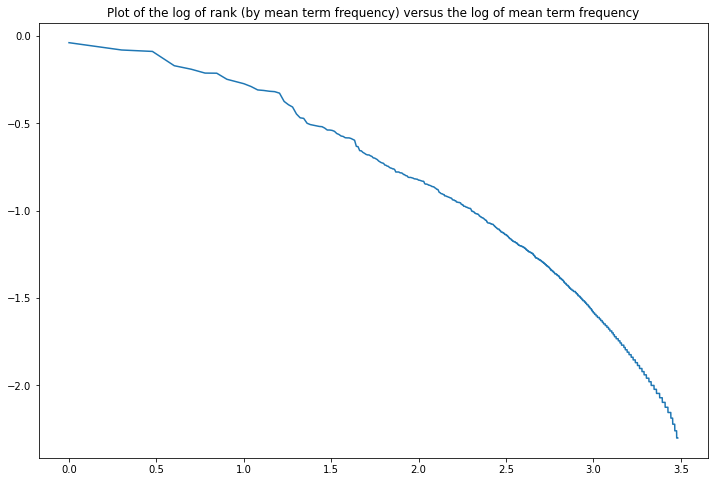

In [31]:
plt.figure(figsize=(12, 8))
ranks = np.arange(len(mean_tf)) + 1
plt.plot(np.log10(ranks), np.log10(mean_tf.values))
plt.title('Plot of the log of rank (by mean term frequency) versus the log of mean term frequency')
plt.show()

This is normally what you see with a vocabulary distribution. Notice, that even though we removed the most common words, and dropped very rare words, by setting `minDF` to 10, we still have the expected distribution.

Now that we have our features and have assured ourselves that we have not disturbed the expected distribution of words, how can we reduce the number of features? We could try and add more words to our stop-word list, or we could increase our `minDF` to remove more rare words. But let's think about a more principled way to approach this. Many of the more well-known techniques for reducing the number of features, for example looking at the univariate predictive power of each feature, will not work well with text. The strength of bag-of-words features is their interactions. So we may throw away features that are not powerful on their own but could be very powerful in combination. The high dimensionality means that we can't explore all the possible interactions. So what can we do?

We can use a dictionary of words or phrases that domain experts have selected as important to the problem. We can also build a tree-based model, for example, random forest, and use the feature importances to select a subset of features. This can work because the random forest model is nonlinear and can discover interactions—so, a word that is important only in combination.

We will look at other techniques for reducing dimensionality in the "Topic Modeling" and "Word Embeddings".  Now, let's discuss the modeling of text using TF.IDF features.

## Modeling

Once you have converted your text into a feature vector, things start to look more like a regular machine learning problem, with some exceptions. The following are the most important things to keep in mind:

There are many sparse features.
These features are not independent of each other.
We have lost a massive part of language by losing the ordering of words.
Fortunately, none of these are showstoppers. Even if an algorithm makes assumptions that are violated by these facts, it can still be effective. We will discuss some popular algorithms here, and we will try out these algorithms in the exercises in this chapter.

### Naïve Bayes
  Naïve Bayes gets its name from its naïve assumption that all the features are mutually independent. It then estimates the probability of a class conditioned on the feature values. We know, from linguistics and common sense, that words are not independent of each other. But naïve Bayes is actually a popular baseline for text classification. The reason naïve Bayes is so popular is that the probability that it produces is similar to TF.IDF:

\begin{equation}
P(class | \text{term}_1, \text{term}_2, ..., \text{term}_N) = \frac{P(class)\prod^N_{i=1}{P(\text{term}_i|class)}}{\sum^K_{k=1}{P(class_k)\prod^N_{i=1}{P(\text{term}_i|class_k)}}}
\end{equation}

If a term is common in all classes, it will not contribute much to this value. However, if a term is unique to the documents in a particular class it will be an important feature for naïve Bayes. This is similar to how IDF reduces the importance of words that are common to many documents.

### Linear Models

Linear models like linear regression and logistic regression assume that their predictors are independent of each other. One way we could get around this is to look at interactions. However, that will not work in our case because we have a very high dimensional space. If you plan on using a linear model, you will likely want to put more effort in your featurization. Specifically, you will want to be more aggressive in reducing the number of features.

### Decision/Regression Trees

Decision and regression trees can learn nonlinear relationships, and they don't have any assumptions of independence. They can be adversely affected by the sparse features. Variables with less inherent entropy, like words that are relatively uncommon, are less likely to be picked for splitting by splitting criteria like information gain. This means that any nonsparse features will be favored over sparse features. Also, words with higher variance, often meaning higher document frequency, can be favored over words with lower document frequency. This can be mitigated, for example, by being more aggressive with stop-word removal. If you are using random forest or gradient boosted trees, you can mitigate some of the difficulties mentioned previously.

Another great aspect of tree-based models is the ability to easily interpret the output of the model. Because you can see which features are being selected, you can easily check if the learning algorithm is making a sensible model.

### Deep Learning Algorithms

Neural networks are great at learning complex functions, but they do require quite a bit of data. The data needed goes up quickly with the number of parameters. If you are using the bag-of-words approach, the number of parameters for the first layer will be the size of your vocabulary times the size of the first hidden layer. This is already quite large. This means that you are spending a lot of time learning intermediate representations for words—which can also lead to overfitting. It is often a good idea to use word embeddings, which we will discuss in #word_embeddings, so that your classification or regression model has far fewer parameters to learn.

Always keep in mind what you want from your data when doing NLP, or machine learning in general. Training and deploying deep learning models is often more complicated than with classical machine learning models. Always try the simplest thing first.

## Iteration

The most important part of any classification or regression project is your iteration cycle.

![How to iterate on NLP classification and regression problems](https://i.imgur.com/7prHD6w.png)  
_How to iterate on NLP classification and regression problems_

If you have done machine learning in the past, most of this will look familiar. There are some differences when working with text data that we should keep in mind, so let's go over the following steps.

1. Get data.

This is often the most time-consuming part of such a project. Hopefully, the data you work with is well-maintained and well-documented. Whether it is or not, you must validate the data.

2. Look at the data.

Whether working with structured or unstructured data, we generally need to do some work to prepare our data for modeling. With structured data, this often means removing invalid values or normalizing a field. With text data this is a little more murky. There may be business logic that dictates a minimum or maximum length. Or perhaps there are certain documents you want to remove based on metadata. Outside of business logic, you should check the encodings of your documents and convert them to a common encoding (e.g., UTF-8).

You also want to create a hold-out set. Even if you are using a form of cross-validation instead of a train-test split, it's important to keep a completely untouched hold-out. It is easy to overfit to text data.

3. Process the data.

Whether working with structured or unstructured data, we generally need to do some work to prepare our data for modeling. In structured data, this often means removing invalid values or normalizing a field. With text data this is a little more murky. There may be business logic that dictates a minimum or maximum length. Or perhaps there are certain documents you want to remove based on metadata. Outside of business logic, you should check the encodings of your documents and convert them to a common encoding (e.g., UTF-8).

You also want to create a hold-out set. Even if you are using a form of cross-validation instead of a train-test split, it's important to keep a completely untouched hold-out. It is often easy to overfit to text data.

4. Featurize.

Now that you have your data processed and ready, you can create feature vectors. After creating features, you should do some basic exploratory analysis of the features. You look at the vocabulary distribution like we did previously. You can also use topic models for this, which we will cover in #topic_modeling. Topic models can give you insights for deciding how to create your model and, as a side benefit, will help you catch errors.

Because NLP featurization is often more complicated than featurization with structured data, you will want to have your featurization stages in the same pipeline as your modeling. This will help optimize model hyperparameters alongside featurization parameters.

5. Model.

You need to decide on which algorithm you want to use. As with general machine learning tasks, you will want to set a baseline. Popular models for setting baselines for text-based classification and regression problems are logistic regression, naïve Bayes, and decision trees. Once you have your features, and you have decided on an algorithm, you can train your model.

6. Evaluate.

Looking at the data is important to understanding what is happening with your model, but looking at metrics is just as important. You should iterate using cross-validation or on a dedicated validation set. Your hold-out set must be saved until you think you are ready to go to production.

7. Review.

It's important to get fresh eyes on as much of your pipeline as possible.

  * Review your code: data processing code can be difficult to review if someone does not have familiarity with the data. If you can't find someone who has context to review your code, having thorough documentation becomes important.
  * Review your data: you can review your data with a subject-matter expert. Also, consider reviewing with someone who is fully unfamiliar with the data.
  * Review your features: the features you've created should make sense. If this is the case, you should review these features with a domain expert. If the features are too abstract to easily tie back to the domain, it might be worthwhile to review the theory behind your features with someone who has experience building similar models.
  * Review your model: when working on a modeling project, it's easy to get lost in the details. It's important to review your rationale for the chosen algorithm, as well as the output.
  * Review your metrics: as with any machine learning project, you should be able to give clear interpretation of your metrics—especially the metric you make business decisions on. If you have a hard time finding a good metric, you may not have the best approach to the problem. Sometimes, a classification problem is better framed as ranking problem.
  * Review your documentation: you should make sure that your whole pipeline is well documented. This is necessary if you want to have reproducibility.

Now that you have validated your baseline model, it's time to make a decision. Is the baseline good enough for production? If so, ship it. Otherwise, it's time to look at the data again. Now you have your cycle set up, and you can start to improve your metrics.



Now we have a framework for building text-based classifiers and regressors. There is no singular technique that makes working with the sparse, high dimensional text easier. You should rely on domain experts to help inform your choices. This chapter covered generic ideas and rules; we will look at more concrete applications in part_application of this book. One issue with the bag-of-words approach is that we lose an important part of language—syntax. We can capture some of that with N-grams, but what happens if we want to classify pieces in the text? In the next chapter, we explore how to build sequence models.

## Exercises

Let's build a classifier to predict the newsgroup that a document belongs to. We will start out with the pipeline we built previously in this chapter, and we will use a naïve Bayes classifier.

Use the [Spark MLlib Guide](https://spark.apache.org/docs/latest/ml-guide.html) as a reference to try new things.

In [47]:
train, test = texts.randomSplit([0.8, 0.2], seed=123)

In [48]:
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

In [49]:
sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

text_processing_pipeline = Pipeline(stages=[
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ])

In [50]:
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

In [51]:
label_indexer = StringIndexer(inputCol='newsgroup', outputCol='label').fit(texts)
naive_bayes = NaiveBayes(featuresCol='tfidf')
prediction_deindexer = IndexToString(inputCol='prediction', outputCol='pred_newsgroup', 
                                     labels=label_indexer.labels)

pipeline = Pipeline(stages=[
    text_processing_pipeline, label_indexer, naive_bayes, prediction_deindexer
])

In [52]:
model = pipeline.fit(train)

In [53]:
train_predicted = model.transform(train)
test_predicted = model.transform(test)

We are using F1-score, which is the harmonic mean of precision and recall.

In [54]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [55]:
print('f1', evaluator.evaluate(train_predicted))

f1 0.940955827768335


In [56]:
print('f1', evaluator.evaluate(test_predicted))

f1 0.6338363272292974


It looks like we are doing much better on the training data than on the testing data—perhaps we are overfitting. Experiment, and see how well you can do on the test set.